In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
import jax
from enum import Enum

In [4]:
RANDOM_KEY = jax.random.PRNGKey(0)
def random_key():
    global RANDOM_KEY
    RANDOM_KEY, key = jax.random.split(RANDOM_KEY)
    return key

In [5]:
def markov_chain(n, transition_matrix, initial_state):
    state = initial_state
    states = [state]
    for i in range(n):
        state = jax.random.choice(random_key(), np.arange(len(transition_matrix)), p=transition_matrix[state])
        states.append(state)
    return states

In [6]:
class State(Enum):
    DARK = 0
    HIGH = 2
    LOW = 1
    HOLIDAY = 3

In [7]:
class Action(Enum):
    STAY = 0
    UP = 1
    DOWN = 2
    SPIKE = 3
    OFF = 4

In [8]:
state_action_map = {
    State.DARK: {
        Action.STAY: State.DARK,
        Action.UP: State.LOW,
        Action.DOWN: State.DARK,
        Action.SPIKE: State.HIGH,
        Action.OFF: State.DARK
    },
    State.HIGH: {
        Action.STAY: State.HIGH,
        Action.UP: State.HOLIDAY,
        Action.DOWN: State.LOW,
        Action.SPIKE: State.HOLIDAY,
        Action.OFF: State.DARK
    },
    State.LOW: {
        Action.STAY: State.LOW,
        Action.UP: State.HIGH,
        Action.DOWN: State.LOW,
        Action.SPIKE: State.HOLIDAY,
        Action.OFF: State.DARK
    },
    State.HOLIDAY: {
        Action.STAY: State.HOLIDAY,
        Action.UP: State.HOLIDAY,
        Action.DOWN: State.HIGH,
        Action.SPIKE: State.HOLIDAY,
        Action.OFF: State.DARK
    }
}

In [9]:
class MarkovChain:
  
  def __init__(self, transition_matrix, initial_state, state_action_map, state_to_dist_map):
    self.transition_matrix = transition_matrix
    self.current_state = initial_state
    self.state_action_map = state_action_map
    self.state_to_dist_map = state_to_dist_map
    
  
  def get_values(self, states):
    return [self.state_to_dist_map[state](random_key()) for state in states]
        
  
  def simulate(self, n):
    state = self.current_state
    states = [state]
    
    for i in range(n-1):
        action = jax.random.choice(random_key(), 
                                   np.arange(len(self.transition_matrix[state.value])), p=self.transition_matrix[state.value])
        state = self._perform_action(state, Action(action))
        states.append(state)
    values = self.get_values(states)
    return states, values
  
  def _perform_action(self, state, action):
    return self.state_action_map[state][action]
  
  def next(self):
    self.current_state = markov_chain(1, self.transition_matrix, self.current_state)[0]
    return self.current_state

  def plot(self, n):
    states = self.simulate(n)
    values = [self.state_to_dist_map[state](random_key()) for state in states]
    plt.plot(values)
    plt.show()
  

In [10]:
action_prob = np.array([
    [0.8, 0.19, 0.0, 0.01, 0.0],
    [0.7, 0.14, 0.15, 0.01, 0.0],
    [0.5, 0.05, 0.35, 0.0, 0.1],
    [0.04, 0.0, 0.95, 0, 0.01]
])
state_to_dist_map = {
    State.DARK: lambda key: 0,
    State.HIGH: lambda key: np.exp(6 + 0.2*jax.random.normal(key, (1,)))[0],
    State.LOW: lambda key: np.exp(4 + 0.5*jax.random.normal(key, (1,)))[0],
    State.HOLIDAY: lambda key: np.exp(7 + 0.05*jax.random.normal(key, (1,)))[0]}

In [11]:
markov_chain = MarkovChain(action_prob, State.DARK, state_action_map, state_to_dist_map=state_to_dist_map)

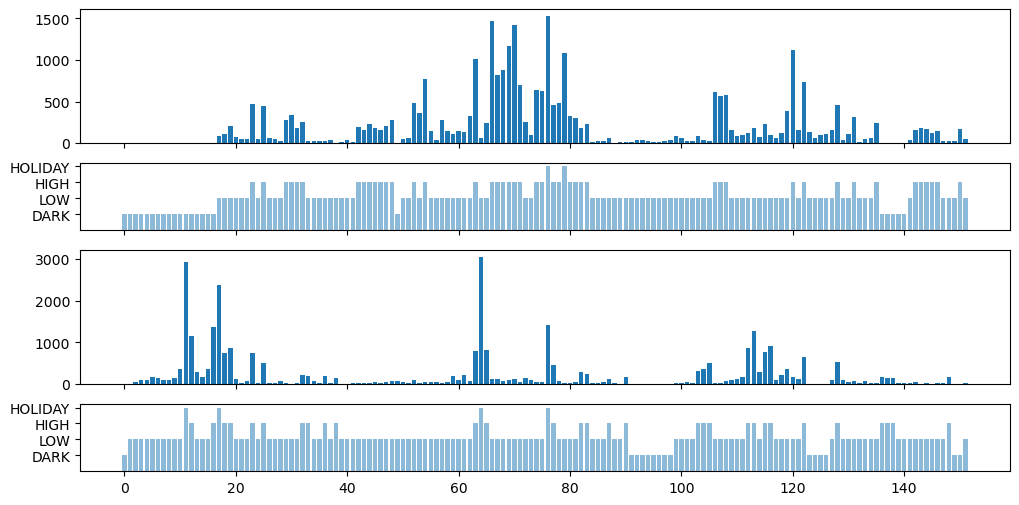

In [17]:
states1, values = markov_chain.simulate(152)
channel1 = values*np.exp(np.sin(2*np.pi*np.arange(152)/52.18))
states2, values = markov_chain.simulate(152)
channel2 = values*np.exp(np.sin(2*np.pi*np.arange(152)/52.18))
states3, values = markov_chain.simulate(152)
channel3 = values*np.exp(np.sin(2*np.pi*np.arange(152)/52.18))
fig, ax = plt.subplots(4, figsize=(12, 6), sharex=True, height_ratios=[2, 1, 2, 1])
ax[0].bar(np.arange(152), channel1)
ax[2].bar(np.arange(152), channel2)
ax[1].bar(np.arange(152), [state.value+1 for state in states1], alpha=0.5)
ax[1].set_yticks([1, 2, 3, 4], ["DARK", "LOW", "HIGH", "HOLIDAY"]);
ax[3].bar(np.arange(152), [state.value+1 for state in states2], alpha=0.5)
ax[3].set_yticks([1, 2, 3, 4], ["DARK", "LOW", "HIGH", "HOLIDAY"]);